In [184]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

TD 3-4

Enoncé : 

------------------------------------------------------------------------------------------------------------------------------------------------------

1/ A partir des données fournies (historique d’une action, colonne B), créez l’historique du portefeuille
de réplication d’un call européen de maturité le 31/12/2018, de strike 6 et de volatilité constante égale
à 20%. Ce portefeuille de réplication a-t-il toujours la valeur de l’option ? Pourquoi ?

2/ On suppose qu’on dispose en plus d’une autre option de mêmes caractéristiques (en particulier une
volatilité de 20%), sinon le strike qui vaut 6.5. On se propose de répliquer notre option initiale en delta
et en gamma. Comment procéder ? Ce nouveau portefeuille de réplication a-t-il toujours la valeur de
l’option ?

3/ Représenter le prix d’un call européen en fonction du paramètre de volatilité et calibrer la volatilité
implicite en utilisant l’algorithme de Newton-Raphson puis l’algorithme de dichotomie.

4/ Estimer l’historique de volatilité implicite pour les deux options dont on a l’historique de prix
(colonnes C et D).

5/ Déterminer rétrospectivement la meilleure couverture dynamique pour la première option (strike
de 6, colonne C), puis proposer un portefeuille de réplication pour la dernière date (pour vous couvrir
jusqu’au lendemain). Vous déposerez votre réponse ici : https://goo.gl/forms/9bobGfSpaU9aRDWF3
(cela contribuera à une partie de la note finale de ce cours, l’absence de réponse fera donc baisser
cette note). Lors de la prochaine séance, le P&L obtenu par votre stratégie de réplication vous sera
dévoilé.


----------------------------------------------------------------------------------------------------------------------------------

On charge les données

In [185]:
data = pd.read_excel("D:\VSCodeWrokSpace\Calibration\Données TD3.xlsx")
data['Date'] = pd.to_datetime(data['Date'])


On plot le prix de l'action

<Figure size 640x480 with 0 Axes>

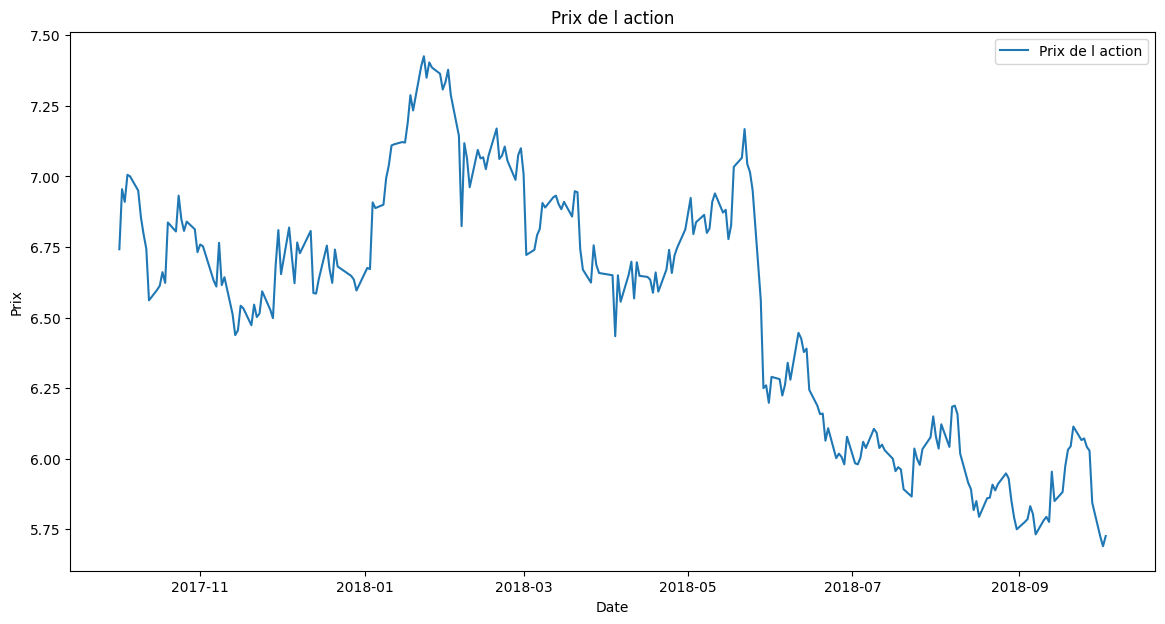

In [186]:
plt.figure()
plt.figure(figsize=(14, 7))
plt.plot(data['Date'],data['Prix action'], label='Prix de l action')
plt.title('Prix de l action')
plt.xlabel('Date')
plt.ylabel('Prix')
plt.legend()
plt.show()

Première question : 

1/ A partir des données fournies (historique d’une action, colonne B), créez l’historique du portefeuille
de réplication d’un call européen de maturité le 31/12/2018, de strike 6 et de volatilité constante égale
à 20%. Ce portefeuille de réplication a-t-il toujours la valeur de l’option ? Pourquoi ? 

Formule de BlackScholes et paramètre du modèle

In [187]:
def black_scholes_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price


strike = 6  
maturity = pd.to_datetime('2018-12-31')  
risk_free_rate = 0.0 
volatility = 0.20  

Calcule du T, temps à maturité

In [188]:
data['TempsTM'] = (maturity - data['Date']).dt.total_seconds() / (365 * 24 * 60 * 60)

Calcul du prix du call en fonction du TTM et prix de l'action

In [189]:
data['Prix Call'] = data.apply(lambda row: black_scholes_call_price(
    S=row['Prix action'],
    K=strike,
    T=row['TempsTM'],
    r=risk_free_rate,
    sigma=volatility), axis=1)

print(data[['Date','TempsTM','Prix action', 'Prix Call']])

          Date   TempsTM  Prix action  Prix Call
0   2017-10-02  1.246575        6.742   1.012460
1   2017-10-03  1.243836        6.955   1.173632
2   2017-10-04  1.241096        6.910   1.138193
3   2017-10-05  1.238356        7.006   1.212687
4   2017-10-06  1.235616        7.000   1.207450
..         ...       ...          ...        ...
252 2018-09-27  0.260274        6.028   0.258953
253 2018-09-28  0.257534        5.844   0.169706
254 2018-10-01  0.249315        5.724   0.120900
255 2018-10-02  0.246575        5.690   0.108709
256 2018-10-03  0.243836        5.726   0.119268

[257 rows x 4 columns]


Calcul du Delta

In [190]:
def delta_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    return delta


data['Delta1'] = data.apply(lambda row: delta_call(
    S = row['Prix action'],
    K = strike,
    T= row ['TempsTM'],
    r= risk_free_rate,
    sigma= volatility), axis =1)


print(data[['Date','TempsTM','Prix action','Prix Call','Delta1']])

          Date   TempsTM  Prix action  Prix Call    Delta1
0   2017-10-02  1.246575        6.742   1.012460  0.736896
1   2017-10-03  1.243836        6.955   1.173632  0.780447
2   2017-10-04  1.241096        6.910   1.138193  0.771918
3   2017-10-05  1.238356        7.006   1.212687  0.790382
4   2017-10-06  1.235616        7.000   1.207450  0.789458
..         ...       ...          ...        ...       ...
252 2018-09-27  0.260274        6.028   0.258953  0.538497
253 2018-09-28  0.257534        5.844   0.169706  0.417298
254 2018-10-01  0.249315        5.724   0.120900  0.336647
255 2018-10-02  0.246575        5.690   0.108709  0.314013
256 2018-10-03  0.243836        5.726   0.119268  0.335814

[257 rows x 5 columns]


Calcul du porteufeuille de réplication

In [191]:
cash_position = [black_scholes_call_price(data['Prix action'][0], strike, data['TempsTM'][0], risk_free_rate, volatility) - data['Delta1'][0] * data['Prix action'][0]]
stock_position = [data['Delta1'][0]]
portfolio_value = [cash_position[0] + stock_position[0] * data['Prix action'][0]]

for i in range(1, len(data)):
    stock_price_change = data['Prix action'][i] - data['Prix action'][i-1]
    cash_position.append(cash_position[-1] - data['Delta1'][i-1] * stock_price_change)
    stock_position.append(data['Delta1'][i])
    portfolio_value.append(cash_position[-1] + stock_position[-1] * data['Prix action'][i])

data['Cash Position'] = cash_position
data['Stock Position'] = stock_position
data['Portfolio Value'] = portfolio_value

print(data[['Date', 'Prix action', 'Prix Call', 'Delta1', 'Cash Position', 'Stock Position', 'Portfolio Value']])


          Date  Prix action  Prix Call    Delta1  Cash Position   
0   2017-10-02        6.742   1.012460  0.736896      -3.955691  \
1   2017-10-03        6.955   1.173632  0.780447      -4.112650   
2   2017-10-04        6.910   1.138193  0.771918      -4.077530   
3   2017-10-05        7.006   1.212687  0.790382      -4.151634   
4   2017-10-06        7.000   1.207450  0.789458      -4.146892   
..         ...          ...        ...       ...            ...   
252 2018-09-27        6.028   0.258953  0.538497      -3.165900   
253 2018-09-28        5.844   0.169706  0.417298      -3.066817   
254 2018-10-01        5.724   0.120900  0.336647      -3.016741   
255 2018-10-02        5.690   0.108709  0.314013      -3.005295   
256 2018-10-03        5.726   0.119268  0.335814      -3.016600   

     Stock Position  Portfolio Value  
0          0.736896         1.012460  
1          0.780447         1.315357  
2          0.771918         1.256421  
3          0.790382         1.385782  


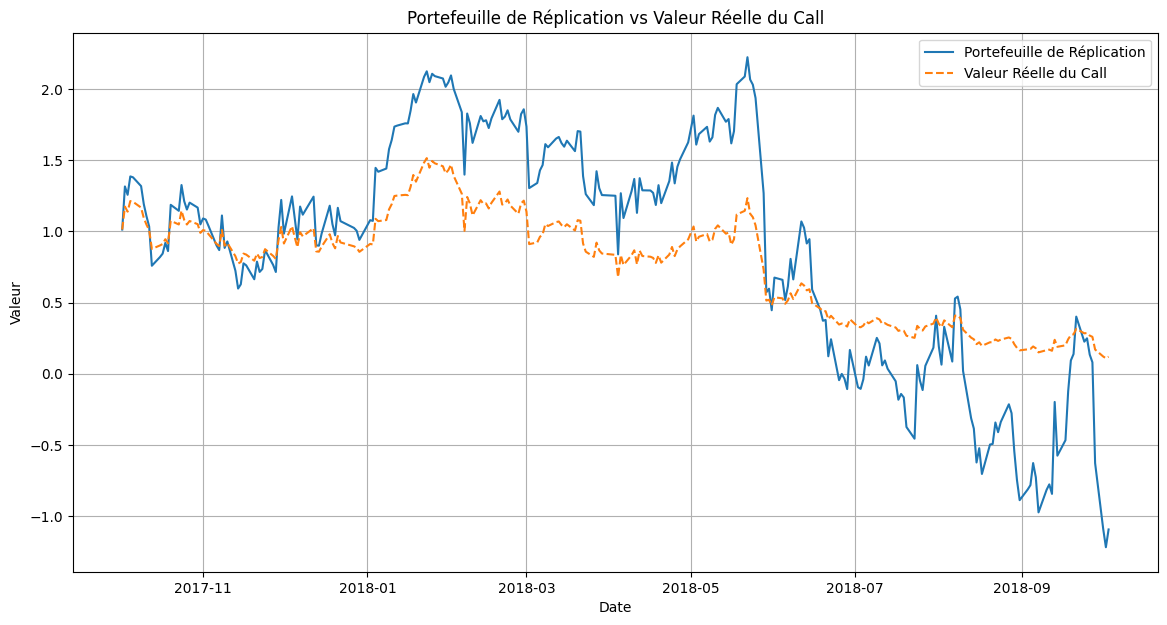

In [192]:
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Portfolio Value'], label='Portefeuille de Réplication')
plt.plot(data['Date'], data['Prix Call'], label='Valeur Réelle du Call', linestyle='--')
plt.title('Portefeuille de Réplication vs Valeur Réelle du Call')
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.legend()
plt.grid(True)
plt.show()

On voit ici que les variations sont quasi les meme mais avec une amplitude différente donc une différence sur la volatilité pour pouvoir couvrir la réplication

------------------------------------------------------------------------------------------------------------------------------------------------------------

2/ On suppose qu’on dispose en plus d’une autre option de mêmes caractéristiques (en particulier une
volatilité de 20%), sinon le strike qui vaut 6.5. On se propose de répliquer notre option initiale en delta
et en gamma. Comment procéder ? Ce nouveau portefeuille de réplication a-t-il toujours la valeur de
l’option ?

------------------------------------------------------------------------------------------------------------------------------------------------------------

Calcul du Gamma

In [193]:
strike2 = 6.5

In [194]:
def gamma_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    return gamma

data['Gamma'] = data.apply(lambda row: gamma_call(
    S=row['Prix action'],
    K=strike2,
    T=row['TempsTM'],
    r=risk_free_rate,
    sigma=volatility), axis=1)

data

,Date,Prix action,Prix option strike 6,"Prix option strike 6,5",TempsTM,Prix Call,Delta1,Cash Position,Stock Position,Portfolio Value,Gamma
0,2017-10-02,6.742,NaN,NaN,1.246575,1.012460,0.736896,-3.955691,0.736896,1.012460,0.255134
1,2017-10-03,6.955,NaN,NaN,1.243836,1.173632,0.780447,-4.112650,0.780447,1.315357,0.235955
2,2017-10-04,6.910,1.02096,0.59093,1.241096,1.138193,0.771918,-4.077530,0.771918,1.256421,0.240523
3,2017-10-05,7.006,1.09932,0.65885,1.238356,1.212687,0.790382,-4.151634,0.790382,1.385782,0.231411
4,2017-10-06,7.000,1.09306,0.65440,1.235616,1.207450,0.789458,-4.146892,0.789458,1.379314,0.232239
...,...,...,...,...,...,...,...,...,...,...,...
252,2018-09-27,6.028,0.37835,0.26191,0.260274,0.258953,0.538497,-3.165900,0.538497,0.080157,0.511987
253,2018-09-28,5.844,0.28498,0.19737,0.257534,0.169706,0.417298,-3.066817,0.417298,-0.628125,0.408992
254,2018-10-01,5.724,0.24261,0.16974,0.249315,0.120900,0.336647,-3.016741,0.336647,-1.089773,0.330316
255,2018-10-02,5.690,0.24491,0.17452,0.246575,0.108709,0.314013,-3.005295,0.314013,-1.218561,0.307024


3/ Représenter le prix d’un call européen en fonction du paramètre de volatilité et calibrer la volatilité
implicite en utilisant l’algorithme de Newton-Raphson puis l’algorithme de dichotomie. 


In [195]:
S0 = 100  
K = 100  
T = 1    
r = 0.05 
market_price = 10

In [196]:
def norm_pdf(x):
    return (1.0 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x * x)

def black_scholes_vega(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S0 * np.sqrt(T) * norm_pdf(d1)


def implied_volatility_newton_raphson(S0, K, T, r, market_price, sigma_initial_guess=0.2, max_iterations=100, epsilon=1e-6):
    sigma = sigma_initial_guess
    for i in range(max_iterations):
        price = black_scholes_call_price(S0, K, T, r, sigma)
        vega = black_scholes_vega(S0, K, T, r, sigma)
        
        # Calcul de la nouvelle estimation de la volatilité (Formule vu en cours)
        sigma = sigma - (price - market_price) / vega
        if abs(price - market_price) < epsilon:
            return sigma
        
    return sigma  

vol_implicite = implied_volatility_newton_raphson(S0, K, T, r, market_price)
print(f"La volatilité implicite est {vol_implicite:.6f}")


La volatilité implicite est 0.187972


4/ Estimer l’historique de volatilité implicite pour les deux options dont on a l’historique de prix
(colonnes C et D). 


In [197]:
strike6 = 6
strike65=6.5

In [198]:
data['VolI6'] = data.apply(lambda row: implied_volatility_newton_raphson(
    S0=row['Prix action'],
    K=strike6,
    T=row['TempsTM'],
    r=risk_free_rate,
    market_price=row['Prix option strike 6']), axis=1)

print(data['VolI6'])

0           NaN
1           NaN
2      0.145860
3      0.144789
4      0.144311
         ...   
252    0.297813
253    0.298548
254    0.312172
255    0.328587
256    0.341453
Name: VolI6, Length: 257, dtype: float64


In [199]:
data['VolI65'] = data.apply(lambda row: implied_volatility_newton_raphson(
    S0=row['Prix action'],
    K=strike65,
    T=row['TempsTM'],
    r=risk_free_rate,
    market_price=row['Prix option strike 6,5']), axis=1)

print(data['VolI65'])

0           NaN
1           NaN
2      0.116967
3      0.116565
4      0.116687
         ...   
252    0.361408
253    0.362253
254    0.376124
255    0.393196
256    0.406829
Name: VolI65, Length: 257, dtype: float64


5/ Déterminer rétrospectivement la meilleure couverture dynamique pour la première option (strike
de 6, colonne C), puis proposer un portefeuille de réplication pour la dernière date (pour vous couvrir
jusqu’au lendemain).

In [200]:
def derivee_approx(f, x, h=0.0001):
        return (f(x + h) - f(x)) / h

Ici on va faire un modèle économétrique pour prédire le prix des options

## Modèle Économétrique pour la Couverture Dynamique

Le modèle économétrique utilisé pour la stratégie de couverture dynamique est basé sur la méthode de régression linéaire. Ce modèle utilise les caractéristiques suivantes pour prédire le prix de l'option :

- `Prix action` : Le prix actuel de l'action sous-jacente.
- `VolI6` : La volatilité implicite de l'option avec un strike de 6.
- `Vega` : La sensibilité du prix de l'option aux changements dans la volatilité implicite.

### Formule du Modèle

Le modèle peut être représenté par la formule suivante :


Prix de l'option prédit est calculé avec la formule suivante :

$$
\text{Prix\_Option}_{\text{prédit}} = \beta_0 + \beta_1 \times \text{Prix\_action} + \beta_2 \times \text{VolI6} + \beta_3 \times \text{Vega}
$$



où :
- $\beta_0$ est l'intercept du modèle,
- $\beta_1$, $\beta_2$, et $\beta_3$ sont les coefficients estimés pour chaque caractéristique par la régression linéaire.
- Et VolI6 est la volatilité implicite de l'option de strike = 6 

### Stratégie de Couverture Dynamique

La stratégie de couverture dynamique implique d'ajuster la position en actions chaque jour pour rester neutre au delta. Pour le dernier jour, le nombre d'actions à acheter est donné par :

$$
Nombre\_Actions = \Delta \cdot Nombre\_Options
$$


où :
- `Nombre_Options` est le nombre total d'options que nous souhaitons couvrir (dans ce cas, c'est 1).


On prepare le dataset 

In [201]:
data_filled = data.fillna(data.mean())

In [202]:
def vega_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T)
    return vega

data_filled['Vega'] = data_filled.apply(lambda row: vega_call(
    S=row['Prix action'],
    K=strike6,
    T=row['TempsTM'],
    r=risk_free_rate,
    sigma=row['VolI6']), axis=1)

X = data_filled[['Prix action', 'VolI6', 'Vega']]
y = data_filled['Prix option strike 6']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Précision du modèle : ", model.score(X_test, y_test))


Précision du modèle :  0.9907707253258702


On obtient une précision exceptionnellemnt, surement car on a pas énormément de data qui sont assez proche ne valeur des unes des autres

In [203]:
derniere_ligne = data_filled.iloc[-1]
derniere_ligne

Date                      2018-10-03 00:00:00
Prix action                             5.726
Prix option strike 6                  0.27191
Prix option strike 6,5                0.19592
TempsTM                              0.243836
Prix Call                            0.119268
Delta1                               0.335814
Cash Position                         -3.0166
Stock Position                       0.335814
Portfolio Value                     -1.093728
Gamma                                 0.32931
VolI6                                0.341453
VolI65                               0.406829
Vega                                 1.107206
Name: 256, dtype: object

Si on calcul seulement avec les données de la dernière sans formule cumulative on obtient le résultat suivant mais ducoup il vaudrai mieux approcher de manière cumulative pour avoir une valeur en fonction de la couverture dynamique en delta, vega

In [204]:

features_dernier_jour = [derniere_ligne['Prix action'], derniere_ligne['VolI6'], derniere_ligne['Vega']]
prix_option_pred = model.predict([features_dernier_jour])[0]


delta_dernier_jour = delta_call(derniere_ligne['Prix action'], strike6, derniere_ligne['TempsTM'], risk_free_rate, derniere_ligne['VolI6'])
nombre_actions = delta_dernier_jour * 1

print(f"Nombre d'actions à acheter pour le dernier jour : {nombre_actions}")



Nombre d'actions à acheter pour le dernier jour : 0.4235111641988004


C:\Users\paull\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Backtest premier essai basique snas calculer de valeur du portefeuille

In [205]:
# Initialisation
nombre_options = 1
actions_detenues = 0  


for date, row in data_filled.iterrows():
    predicted_option_price = model.predict([[row['Prix action'], row['VolI6'], row['Vega']]])[0]
    delta = delta_call(row['Prix action'], strike6, row['TempsTM'], risk_free_rate, row['VolI6'])
    
    
    actions_a_acheter = delta * nombre_options - actions_detenues
    actions_detenues += actions_a_acheter

derniere_action_a_acheter = actions_detenues

print(f"Nombre d'actions à acheter pour la dernière date : {derniere_action_a_acheter}")


Nombre d'actions à acheter pour la dernière date : 0.4235111641988004


C:\Users\paull\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\paull\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\paull\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\paull\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\paull\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Backtest en ajustant à chaque date 

In [206]:
nombre_options = 1
actions_detenues = 0
capital_initial = 100000  
donnees_backtest = []

for date, row in data_filled.iterrows():
    
    features_for_prediction = pd.DataFrame([[row['Prix action'], row['VolI6'], row['Vega']]], 
                                           columns=['Prix action', 'VolI6', 'Vega'])
    predicted_option_price = model.predict(features_for_prediction)[0]    
    delta = delta_call(row['Prix action'], strike6, T, risk_free_rate, row['VolI6'])
    
    actions_a_acheter = delta * nombre_options - actions_detenues
    actions_detenues += actions_a_acheter
    valeur_actions = actions_detenues * row['Prix action']
    valeur_portefeuille = valeur_actions + capital_initial

    donnees_backtest.append({
        'Date': date,
        'Delta': delta,  
        'Valeur_Portefeuille': valeur_portefeuille,
        'Prix_Option': predicted_option_price,
        'Prix_Action': row['Prix action']
    })

resultats_backtest = pd.DataFrame(donnees_backtest)
resultats_backtest['Date'] = pd.to_datetime(resultats_backtest['Date'])
resultats_backtest.set_index('Date', inplace=True)


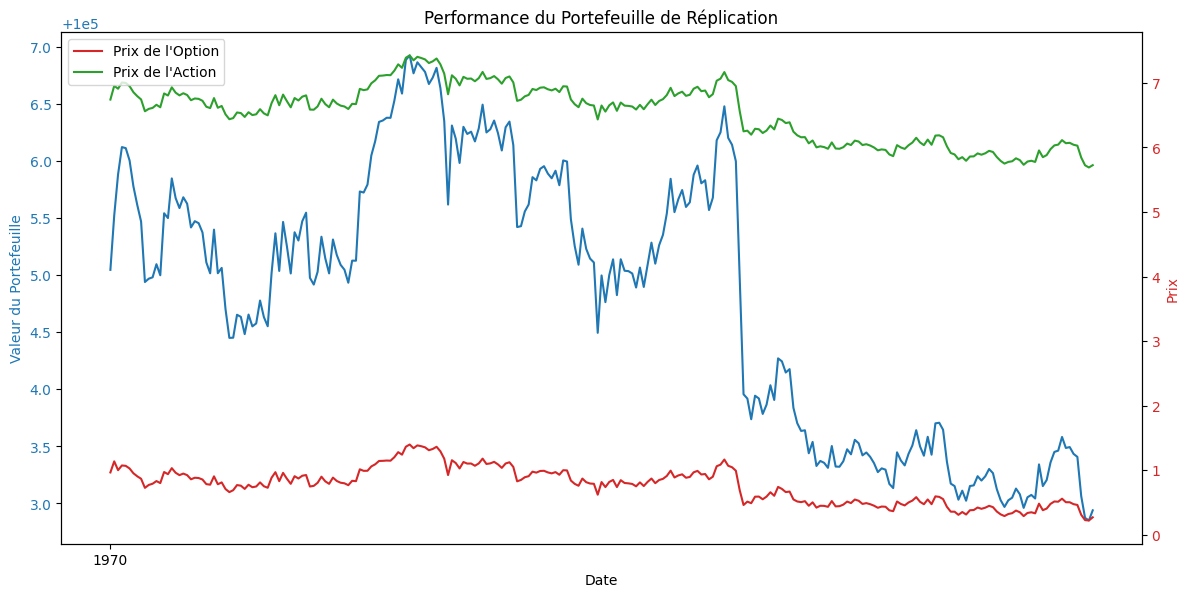

In [207]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Valeur du Portefeuille', color=color)
ax1.plot(resultats_backtest.index, resultats_backtest['Valeur_Portefeuille'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instancier un deuxième axe y partageant le même axe x
ax2 = ax1.twinx() 
color = 'tab:red'
ax2.set_ylabel('Prix', color=color)
ax2.plot(resultats_backtest.index, resultats_backtest['Prix_Option'], color=color, label='Prix de l\'Option')
ax2.plot(resultats_backtest.index, resultats_backtest['Prix_Action'], color='tab:green', label='Prix de l\'Action')
ax2.tick_params(axis='y', labelcolor=color)

# Légende combinée des deux axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

fig.tight_layout()  # Pour s'assurer que la mise en page s'adapte bien
plt.title('Performance du Portefeuille de Réplication')
plt.show()


Ici on va plot le portefeuille de réplication

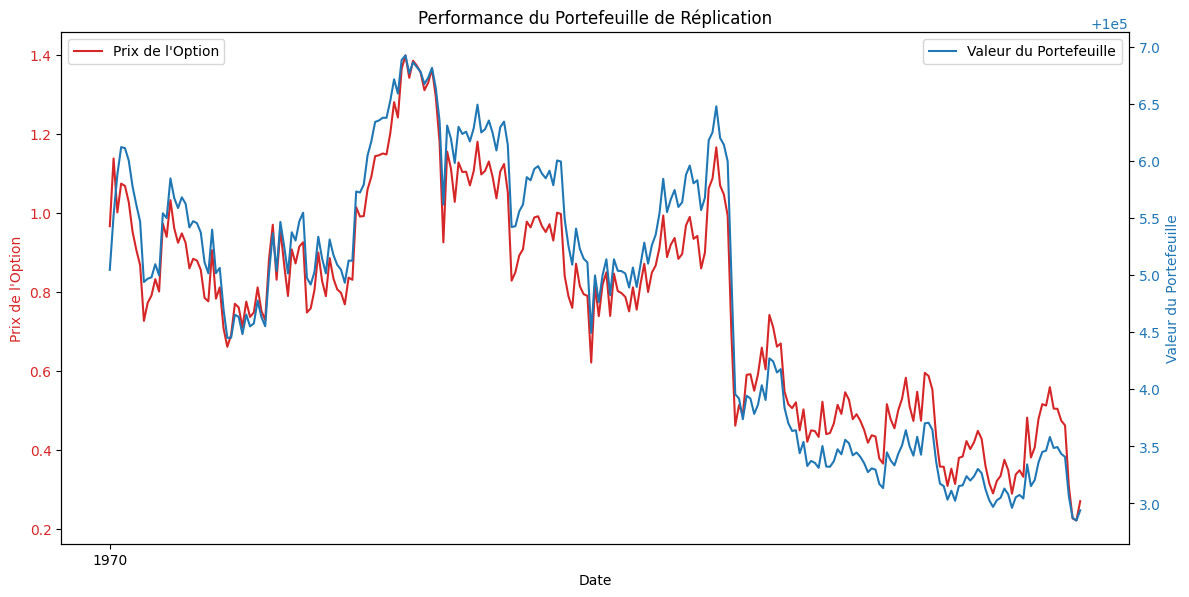

In [208]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Prix de l\'Option', color='tab:red')
ax1.plot(resultats_backtest.index, resultats_backtest['Prix_Option'], color='tab:red', label='Prix de l\'Option')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx() 
ax2.set_ylabel('Valeur du Portefeuille', color='tab:blue')
ax2.plot(resultats_backtest.index, resultats_backtest['Valeur_Portefeuille'], color='tab:blue', label='Valeur du Portefeuille')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()  
plt.title('Performance du Portefeuille de Réplication')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()


Pn voit que notre stratégie est assez performante surtout à la fin donc on va prendre cette valeur de delta 


In [209]:
delta_dernier_jour = resultats_backtest['Delta'].iloc[-1]
nombre_actions = delta_dernier_jour * nombre_options  

print(f"Le nombre d'actions à acheter pour le dernier jour est : {nombre_actions}")


Le nombre d'actions à acheter pour le dernier jour est : 0.513495435148786


Couverture en utilisant deux titres.
Vous vous couvrez en investissant maintenant sur l'action et sur l'autre option.

Combien voulez-vous détenir d'actions ?
Combien voulez-vous détenir de l'autre option ?


In [213]:
data_filled['Vega'] = data_filled.apply(lambda row: vega_call(
    S=row['Prix action'],
    K=strike65,
    T=row['TempsTM'],
    r=risk_free_rate,
    sigma=row['VolI65']), axis=1)

X2 = data_filled[['Prix action', 'VolI65', 'Vega']]
y2 = data_filled['Prix option strike 6,5']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

model_6_5 = LinearRegression()
model_6_5.fit(X_train2, y_train2)
y_pred2 = model_6_5.predict(X_test2)
print("Précision du modèle : ", model_6_5.score(X_test2, y_test2))


Précision du modèle :  0.9677515873527026


In [215]:
features_dernier_jour_6 = [derniere_ligne['Prix action'], derniere_ligne['VolI6'], derniere_ligne['Vega']]
prix_option_pred_6 = model.predict([features_dernier_jour_6])[0]

features_dernier_jour_6_5 = [derniere_ligne['Prix action'], derniere_ligne['VolI65'], derniere_ligne['Vega']]
prix_option_pred_6_5 = model_6_5.predict([features_dernier_jour_6_5])[0]

# Calculer le delta pour la dernière date pour chaque option
delta_option_strike_6 = delta_call(derniere_ligne['Prix action'], strike6, derniere_ligne['TempsTM'], risk_free_rate, derniere_ligne['VolI6'])
delta_option_strike_6_5 = delta_call(derniere_ligne['Prix action'], strike65, derniere_ligne['TempsTM'], risk_free_rate, derniere_ligne['VolI65'])

# Déterminer le nombre d'actions à détenir
nombre_actions_pour_option_6 = delta_option_strike_6 * 1

# Déterminer le nombre d'options de strike 6,5 à détenir
# Vous pouvez ajuster cette formule en fonction de votre stratégie de couverture spécifique
nombre_options_pour_strike_6_5 = -delta_option_strike_6 * 1 / delta_option_strike_6_5

print(f"Nombre d'actions à acheter pour le dernier jour : {nombre_actions_pour_option_6}")
print(f"Nombre d'options de strike 6,5 à détenir : {nombre_options_pour_strike_6_5}")


Nombre d'actions à acheter pour le dernier jour : 0.4235111641988004
Nombre d'options de strike 6,5 à détenir : -1.4220154945022567


C:\Users\paull\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\paull\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [219]:
nombre_options2 = 1
actions_detenues2 = 0
options_strike_6_5_detenues = 0
capital_initial2 = 100000  
donnees_backtest2 = []

for date, row in data_filled.iterrows():
    # Prédiction du prix des options et calcul des deltas pour chaque strike
    features_for_prediction_6 = pd.DataFrame([[row['Prix action'], row['VolI6'], row['Vega']]], columns=['Prix action', 'VolI6', 'Vega'])
    predicted_option_price_6 = model.predict(features_for_prediction_6)[0]
    delta_6 = delta_call(row['Prix action'], strike6, T, risk_free_rate, row['VolI6'])

    features_for_prediction_6_5 = pd.DataFrame([[row['Prix action'], row['VolI65'], row['Vega']]], columns=['Prix action', 'VolI65', 'Vega'])
    predicted_option_price_6_5 = model_6_5.predict(features_for_prediction_6_5)[0]
    delta_6_5 = delta_call(row['Prix action'], strike65, T, risk_free_rate, row['VolI65'])

    # Mise à jour de la position en actions
    actions_a_acheter2 = delta_6_5 * nombre_options2 - actions_detenues2
    actions_detenues2 += actions_a_acheter2

    # Mise à jour de la position en options de strike à 6,5
    options_strike_6_5_a_acheter = -delta_6 * nombre_options2 / delta_6_5 - options_strike_6_5_detenues
    options_strike_6_5_detenues += options_strike_6_5_a_acheter

    valeur_actions2 = actions_detenues2 * row['Prix action']
    valeur_portefeuille2 = valeur_actions2 + capital_initial2  # Ajustez selon votre stratégie de capital

    donnees_backtest2.append({
        'Date': date,
        'Delta_6': delta_6,
        'Delta_6_5': delta_6_5,
        'Valeur_Portefeuille': valeur_portefeuille2,
        'Prix_Option_6': predicted_option_price_6,
        'Prix_Option_6_5': predicted_option_price_6_5,
        'Prix_Action': row['Prix action'],
        'Actions_Detenues': actions_detenues2,
        'Options_6_5_Detenues': options_strike_6_5_detenues
    })

resultats_backtest2 = pd.DataFrame(donnees_backtest2)
resultats_backtest2['Date'] = pd.to_datetime(resultats_backtest2['Date'])
resultats_backtest2.set_index('Date', inplace=True)


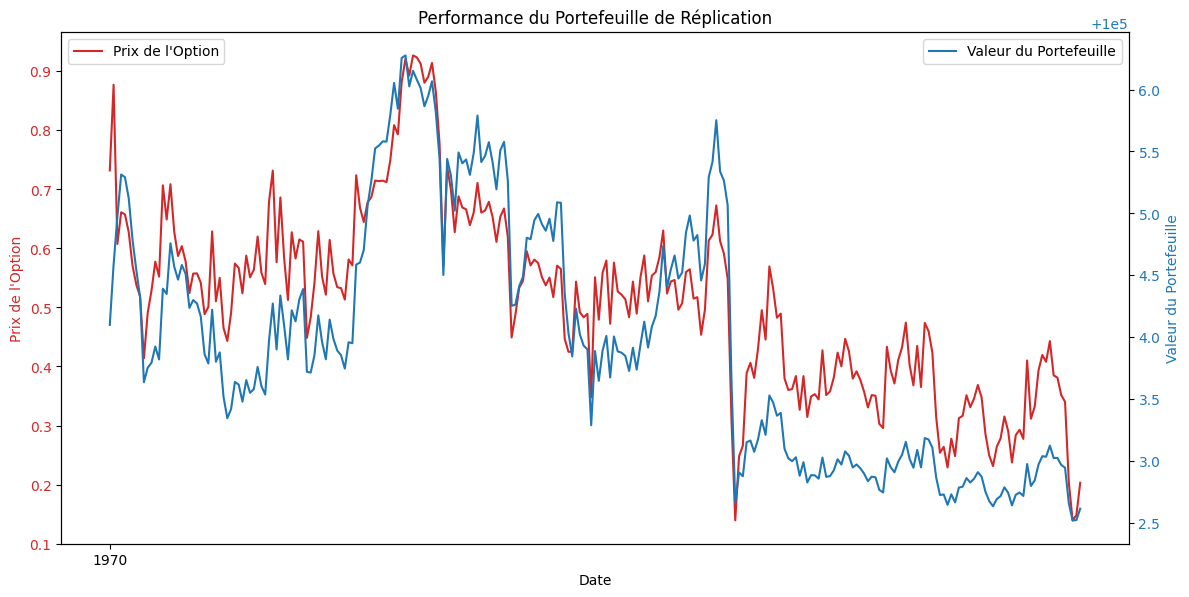

In [224]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Prix de l\'Option', color='tab:red')
ax1.plot(resultats_backtest2.index, resultats_backtest2['Prix_Option_6_5'], color='tab:red', label='Prix de l\'Option')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx() 
ax2.set_ylabel('Valeur du Portefeuille', color='tab:blue')
ax2.plot(resultats_backtest2.index, resultats_backtest2['Valeur_Portefeuille'], color='tab:blue', label='Valeur du Portefeuille')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()  
plt.title('Performance du Portefeuille de Réplication')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()


In [225]:
dernieres_donnees2 = resultats_backtest2.iloc[-1]

nombre_actions_final2 = dernieres_donnees2['Actions_Detenues']
nombre_options_6_5_final = dernieres_donnees2['Options_6_5_Detenues']

print(f"Nombre d'actions à détenir à la fin de la période : {nombre_actions_final2}")
print(f"Nombre d'options de strike à 6,5 à détenir à la fin de la période : {nombre_options_6_5_final}")

Nombre d'actions à détenir à la fin de la période : 0.45690769576189044
Nombre d'options de strike à 6,5 à détenir à la fin de la période : -1.1238493899572777
